In [1]:
import math
import os
import random
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE


device(type='cpu')

In [2]:
CSV_PATH = "../../Data/eth_final_df.csv"

df = pd.read_csv(CSV_PATH)
if "timestamp" not in df.columns:
    raise ValueError("Expected a datetime column named 'timestamp' in the CSV.")
df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True, errors="coerce")
df = df.sort_values("timestamp").dropna(subset=["timestamp"]).reset_index(drop=True)

TARGET_CANDIDATES = ["vol_future", "target", "y"]
target_col = None
for c in TARGET_CANDIDATES:
    if c in df.columns:
        target_col = c
        break
if target_col is None:
    raise ValueError(f"Could not find a target column among {TARGET_CANDIDATES}. "
                     "Please rename your target to one of these or edit the list.")

feature_cols = [c for c in df.columns if c not in ["timestamp", target_col]]
num_cols = [c for c in feature_cols if pd.api.types.is_numeric_dtype(df[c])]
X_raw = df[["timestamp"] + num_cols].copy()
y_raw = df[["timestamp", target_col]].copy()


In [3]:
n_total = len(X_raw)
split_idx = int(n_total * 0.85)
print(split_idx)
X_train_raw = X_raw[:split_idx]
y_train_raw = y_raw[:split_idx]
X_test_raw = X_raw[split_idx+1:]
y_test_raw = y_raw[split_idx+1:]

6976


In [4]:
def make_sequences(X_df: pd.DataFrame,
                   y_df: pd.DataFrame,
                   seq_len: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    dfm = X_df.merge(y_df, on="timestamp", how="inner")
    dfm = dfm.sort_values("timestamp").reset_index(drop=True)

    values = dfm[num_cols].values.astype(np.float32)
    target = dfm[target_col].values.astype(np.float32)
    times  = dfm["timestamp"].values

    X_list, y_list, t_list = [], [], []
    for i in range(len(dfm) - seq_len + 1):
        X_list.append(values[i:i+seq_len])
        y_list.append(target[i+seq_len-1])   
        t_list.append(times[i+seq_len-1])

    return np.stack(X_list), np.array(y_list), np.array(t_list)


In [5]:
class DenseAttention(nn.Module):
    def __init__(self, d_model: int, sentence_length: int, attn_dropout: float = 0.1):
        super().__init__()
        self.sentence_length = sentence_length
        self.w_1 = nn.Linear(d_model, 64)
        self.w_2 = nn.Linear(64, sentence_length)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(attn_dropout)

    def forward(self, q: torch.Tensor, v: torch.Tensor, len_q: int, mask: torch.Tensor = None):
        dense_attn = self.w_2(self.relu(self.w_1(q)))[:, :, :len_q]  
        if mask is not None:
            dense_attn = dense_attn.masked_fill(mask == 0, float("-inf"))

        dense_attn = torch.softmax(dense_attn, dim=-1)
        dense_attn = self.dropout(dense_attn)                       
        output = torch.bmm(dense_attn, v)                        
        return output, dense_attn


class SynthDenseEncoderLayer(nn.Module):
    def __init__(self, d_model: int, dim_feedforward: int, dropout: float, seq_len: int):
        super().__init__()
        self.self_attn = DenseAttention(d_model, sentence_length=seq_len, attn_dropout=dropout)
        self.norm1   = nn.LayerNorm(d_model)
        self.norm2   = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

        self.ffn = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, d_model),
        )

    def forward(self, x: torch.Tensor, attn_mask: torch.Tensor = None):
        x_norm = self.norm1(x)
        attn_out, _ = self.self_attn(x_norm, x_norm, len_q=x_norm.size(1), mask=attn_mask)  # [B,T,d]
        x = x + self.dropout1(attn_out)

        y = self.norm2(x)
        y = self.ffn(y)
        x = x + self.dropout2(y)
        return x


In [6]:
class SeqDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = torch.from_numpy(X)  
        self.y = torch.from_numpy(y).float().view(-1, 1)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 10000):
        super().__init__()
        pe = torch.zeros(max_len, d_model) 
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2)*(-math.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(position*div_term)
        pe[:, 1::2] = torch.cos(position*div_term)
        self.register_buffer("pe", pe.unsqueeze(0))  
    def forward(self, x):
        T = x.size(1)
        return x + self.pe[:, :T, :]

class TimeSeriesSynthesizerDense(nn.Module):
    def __init__(self, n_features: int, d_model: int, nhead: int,  
                 num_layers: int, dim_feedforward: int, dropout: float, seq_len: int):
        super().__init__()
        self.input_proj = nn.Linear(n_features, d_model)
        self.pos_enc = PositionalEncoding(d_model)  
        self.layers = nn.ModuleList([
            SynthDenseEncoderLayer(d_model=d_model,
                                   dim_feedforward=dim_feedforward,
                                   dropout=dropout,
                                   seq_len=seq_len)
            for _ in range(num_layers)
        ])
        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, 1)
        )

    def forward(self, x):
        # x: [B, T, F]
        x = self.input_proj(x)        
        x = self.pos_enc(x)          
        attn_mask = None              
        for layer in self.layers:
            x = layer(x, attn_mask)   
        z_last = x[:, -1, :]          
        return self.head(z_last)      


In [7]:
def make_purged_rolling_splits(timestamps: np.ndarray,
                               n_folds: int = 5,
                               purge_hours: int = 1) -> List[Tuple[np.ndarray, np.ndarray]]:
    ts = pd.to_datetime(pd.Series(timestamps)).sort_values().reset_index(drop=True)
    t_min, t_max = ts.iloc[0], ts.iloc[-1]
    cut_times = [t_min + i*(t_max - t_min)/n_folds for i in range(n_folds+1)]

    splits = []
    for f in range(n_folds):
        train_end = cut_times[f]          
        val_end   = cut_times[f+1]
        all_idx = pd.Series(range(len(ts)))
        train_mask = ts <= train_end
        purge_end = train_end + pd.Timedelta(hours=purge_hours)
        val_mask = (ts > purge_end) & (ts <= val_end)

        tr_idx = all_idx[train_mask].values
        va_idx = all_idx[val_mask].values

        if len(tr_idx) == 0 or len(va_idx) == 0:
            continue
        splits.append((tr_idx, va_idx))
    return splits

In [8]:
@dataclass
class TrainConfig:
    seq_len: int = 1
    batch_size: int = 64
    lr: float = 1e-3
    weight_decay: float = 1e-4
    max_epochs: int = 50
    patience: int = 7
    d_model: int = 64
    nhead: int = 4
    num_layers: int = 2
    dim_feedforward: int = 128
    dropout: float = 0.1

def rmse(y_true, y_pred): 
    return math.sqrt(mean_squared_error(y_true, y_pred))

def rmpse(y_true, y_pred, eps: float = 1e-8):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    pct = ((y_pred - y_true) / (np.abs(y_true) + eps))**2
    return float(np.sqrt(np.mean(pct)))

def qlike_variance(v_true, v_pred, eps: float = 1e-12) -> float:
    v_true = np.asarray(v_true, dtype=float)
    v_pred = np.asarray(v_pred, dtype=float)
    v_true = np.maximum(v_true, eps)
    v_pred = np.maximum(v_pred, eps)
    ratio = v_true / v_pred
    return float(np.mean(ratio - np.log(ratio) - 1.0))

def train_one(model, train_loader, val_loader, cfg: TrainConfig):
    model.to(DEVICE)
    opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    best_state = None
    best_val = float("inf")
    no_improve = 0

    for epoch in range(cfg.max_epochs):
        model.train()
        for xb, yb in train_loader:
            xb = xb.to(DEVICE); yb = yb.to(DEVICE)
            pred = model(xb)
            loss = nn.MSELoss()(pred, yb)
            opt.zero_grad(); loss.backward(); opt.step()

        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(DEVICE); yb = yb.to(DEVICE)
                pred = model(xb)
                val_losses.append(nn.MSELoss()(pred, yb).item())
        val_mse = float(np.mean(val_losses))
        if val_mse < best_val - 1e-7:
            best_val = val_mse
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
            no_improve = 0
        else:
            no_improve += 1
        if no_improve >= cfg.patience:
            break

    if best_state is not None:
        model.load_state_dict(best_state)
    return model, best_val


In [9]:
def fold_score(cfg: TrainConfig,
               X_df: pd.DataFrame,
               y_df: pd.DataFrame,
               n_folds: int = 5,
               purge_hours: int = 1) -> Dict[str, float]:
    X_seq_raw, y_raw_vals, t_idx = make_sequences(X_df, y_df, seq_len=cfg.seq_len)

    splits = make_purged_rolling_splits(t_idx, n_folds=n_folds, purge_hours=purge_hours)
    if len(splits) == 0:
        raise ValueError("No valid folds constructed. Check your data coverage and seq_len.")

    rmse_list, rmpse_list, qlike_list = [], [], []
    for tr_idx, va_idx in splits:
        feat_scaler = RobustScaler()
        targ_scaler = StandardScaler()

        X_train = X_seq_raw[tr_idx]
        y_train = y_raw_vals[tr_idx]
        X_val   = X_seq_raw[va_idx]
        y_val   = y_raw_vals[va_idx]

        B, T, F = X_train.shape
        feat_scaler.fit(X_train.reshape(B*T, F))
        X_train_s = feat_scaler.transform(X_train.reshape(B*T, F)).reshape(B, T, F)
        X_val_s   = feat_scaler.transform(X_val.reshape(X_val.shape[0]*T, F)).reshape(X_val.shape[0], T, F)

        y_train_s = targ_scaler.fit_transform(y_train.reshape(-1,1)).ravel()
        y_val_s   = targ_scaler.transform(y_val.reshape(-1,1)).ravel()

        ds_tr = SeqDataset(X_train_s, y_train_s)
        ds_va = SeqDataset(X_val_s,   y_val_s)
        dl_tr = DataLoader(ds_tr, batch_size=cfg.batch_size, shuffle=True,  drop_last=False)
        dl_va = DataLoader(ds_va, batch_size=cfg.batch_size, shuffle=False, drop_last=False)

        model = TimeSeriesSynthesizerDense(
        n_features=X_train.shape[-1],
        d_model=cfg.d_model,
        nhead=cfg.nhead,                  
        num_layers=cfg.num_layers,
        dim_feedforward=cfg.dim_feedforward,
        dropout=cfg.dropout,
        seq_len=cfg.seq_len      
        )         

        model, _ = train_one(model, dl_tr, dl_va, cfg)

        model.eval()
        yhat_s = []
        with torch.no_grad():
            for xb, _ in dl_va:
                yhat_s.append(model(xb.to(DEVICE)).cpu().numpy().ravel())
        yhat_s = np.concatenate(yhat_s)
        yhat = targ_scaler.inverse_transform(yhat_s.reshape(-1,1)).ravel()
        y_gt = y_val
        v_true = np.square(np.exp(y_gt))  
        v_pred = np.square(np.exp(yhat))

        rmse_list.append(rmse(v_true, v_pred))
        rmpse_list.append(rmpse(v_true, v_pred))
        qlike_list.append(qlike_variance(v_true, v_pred))

    return {
        "RMSE":  float(np.mean(rmse_list)),
        "RMPSE": float(np.mean(rmpse_list)),
        "QLIKE": float(np.mean(qlike_list)),
    }

In [10]:
from itertools import product

SEARCH_SPACE = {
    "seq_len":         [1],
    "batch_size":      [8, 32, 64, 128],
    "lr":              [1e-3, 3e-4, 1e-4],
    "weight_decay":    [1e-5, 1e-4, 3e-4],
    "d_model":         [64, 96, 128],
    "nhead":           [2, 4, 8],
    "num_layers":      [1, 2, 3],
    "dim_feedforward": [128, 256, 384],
    "dropout":         [0.1, 0.2, 0.3],
    "max_epochs":      [40, 60],
    "patience":        [6, 8],
}

def sample_cfg() -> TrainConfig:
    def s(k): return random.choice(SEARCH_SPACE[k])
    return TrainConfig(
        seq_len=s("seq_len"),
        batch_size=s("batch_size"),
        lr=s("lr"),
        weight_decay=s("weight_decay"),
        d_model=s("d_model"),
        nhead=s("nhead"),
        num_layers=s("num_layers"),
        dim_feedforward=s("dim_feedforward"),
        dropout=s("dropout"),
        max_epochs=s("max_epochs"),
        patience=s("patience"),
    )

N_TRIALS = 20
results = []
for t in range(N_TRIALS):
    cfg = sample_cfg()
    scores = fold_score(cfg, X_train_raw, y_train_raw, n_folds=5, purge_hours=1)
    row = {"trial": t, **scores, **cfg.__dict__}
    results.append(row)
    print(f"[{t+1}/{N_TRIALS}] RMSE={scores['RMSE']:.6f}  RMPSE={scores['RMPSE']:.6f}  QLIKE={scores['QLIKE']:.8f}  cfg={cfg}")

res_df = pd.DataFrame(results)

res_df = res_df.sort_values("RMSE", ascending=True).reset_index(drop=True)
res_df.head(10)


[1/20] RMSE=0.000189  RMPSE=2.831388  QLIKE=0.69231249  cfg=TrainConfig(seq_len=1, batch_size=8, lr=0.0001, weight_decay=0.0001, max_epochs=40, patience=8, d_model=64, nhead=2, num_layers=1, dim_feedforward=384, dropout=0.1)
[2/20] RMSE=0.000199  RMPSE=3.570775  QLIKE=0.66691720  cfg=TrainConfig(seq_len=1, batch_size=8, lr=0.001, weight_decay=1e-05, max_epochs=40, patience=8, d_model=64, nhead=8, num_layers=3, dim_feedforward=128, dropout=0.3)
[3/20] RMSE=0.000184  RMPSE=2.173146  QLIKE=0.60561180  cfg=TrainConfig(seq_len=1, batch_size=128, lr=0.0001, weight_decay=0.0001, max_epochs=60, patience=6, d_model=64, nhead=2, num_layers=3, dim_feedforward=256, dropout=0.2)
[4/20] RMSE=0.000204  RMPSE=4.122633  QLIKE=0.76103809  cfg=TrainConfig(seq_len=1, batch_size=64, lr=0.001, weight_decay=1e-05, max_epochs=60, patience=6, d_model=96, nhead=2, num_layers=2, dim_feedforward=256, dropout=0.3)
[5/20] RMSE=0.000212  RMPSE=5.597315  QLIKE=0.75336184  cfg=TrainConfig(seq_len=1, batch_size=8, lr=0

,trial,RMSE,RMPSE,QLIKE,seq_len,batch_size,lr,weight_decay,max_epochs,patience,d_model,nhead,num_layers,dim_feedforward,dropout
0,8,0.000182,2.205211,0.668333,1,8,0.0003,0.00010,60,6,96,2,1,384,0.3
1,14,0.000183,1.940061,0.602021,1,8,0.0010,0.00010,40,6,96,2,1,128,0.3
2,2,0.000184,2.173146,0.605612,1,128,0.0001,0.00010,60,6,64,2,3,256,0.2
3,7,0.000185,1.698309,0.610234,1,128,0.0003,0.00010,60,6,128,8,3,128,0.3
4,18,0.000187,2.540836,0.661596,1,8,0.0010,0.00001,60,8,64,4,1,384,0.1
5,15,0.000188,2.060469,0.750671,1,8,0.0001,0.00001,60,8,64,8,2,384,0.1
6,17,0.000188,2.238905,0.615282,1,32,0.0010,0.00010,40,6,64,8,3,128,0.3
7,0,0.000189,2.831388,0.692312,1,8,0.0001,0.00010,40,8,64,2,1,384,0.1
8,11,0.000191,2.403746,0.702016,1,8,0.0003,0.00010,40,6,128,4,3,256,0.3
9,19,0.000196,3.404940,0.727439,1,32,0.0001,0.00030,40,6,128,4,1,256,0.2


In [11]:
best_cfg_dict = res_df.iloc[0].to_dict()
best_cfg = TrainConfig(
    seq_len=int(best_cfg_dict["seq_len"]),
    batch_size=int(best_cfg_dict["batch_size"]),
    lr=float(best_cfg_dict["lr"]),
    weight_decay=float(best_cfg_dict["weight_decay"]),
    d_model=int(best_cfg_dict["d_model"]),
    nhead=int(best_cfg_dict["nhead"]),
    num_layers=int(best_cfg_dict["num_layers"]),
    dim_feedforward=int(best_cfg_dict["dim_feedforward"]),
    dropout=float(best_cfg_dict["dropout"]),
    max_epochs=int(best_cfg_dict["max_epochs"]),
    patience=int(best_cfg_dict["patience"]),
)

In [12]:
X_seq, y_seq, t_seq = make_sequences(X_raw, y_raw, seq_len=best_cfg.seq_len)
n_total = len(X_seq)
split_idx = int(n_total * 0.85)

X_train, X_test = X_seq[:split_idx], X_seq[split_idx+1:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx+1:]
t_train, t_test = t_seq[:split_idx], t_seq[split_idx+1:]

In [13]:
feat_scaler = RobustScaler()
targ_scaler = StandardScaler()

B, T, Fdim = X_train.shape
feat_scaler.fit(X_train.reshape(B*T, Fdim))
X_train_s = feat_scaler.transform(X_train.reshape(B*T, Fdim)).reshape(B, T, Fdim)
X_test_s  = feat_scaler.transform(X_test.reshape(X_test.shape[0]*T, Fdim)).reshape(X_test.shape[0], T, Fdim)

y_train_s = targ_scaler.fit_transform(y_train.reshape(-1,1)).ravel()
y_test_s  = targ_scaler.transform(y_test.reshape(-1,1)).ravel()

ds_tr = SeqDataset(X_train_s, y_train_s)
ds_te = SeqDataset(X_test_s,  y_test_s)
dl_tr = DataLoader(ds_tr, batch_size=best_cfg.batch_size, shuffle=True)
dl_te = DataLoader(ds_te, batch_size=best_cfg.batch_size, shuffle=False)

model = TimeSeriesSynthesizerDense(
    n_features=X_train.shape[-1],
    d_model=best_cfg.d_model,
    nhead=best_cfg.nhead,                 
    num_layers=best_cfg.num_layers,
    dim_feedforward=best_cfg.dim_feedforward,
    dropout=best_cfg.dropout,
    seq_len=best_cfg.seq_len               
)
model, _ = train_one(model, dl_tr, dl_te, best_cfg)


In [14]:
model.eval()
yhat_s = []
with torch.no_grad():
    for xb, _ in dl_te:
        xb = xb.to(DEVICE)
        yhat_s.append(model(xb).cpu().numpy().ravel())
yhat_s = np.concatenate(yhat_s)

yhat = targ_scaler.inverse_transform(yhat_s.reshape(-1,1)).ravel()
y_true = y_test
t_test = pd.to_datetime(t_test)

y_true = np.exp(y_true) 
yhat = np.exp(yhat)


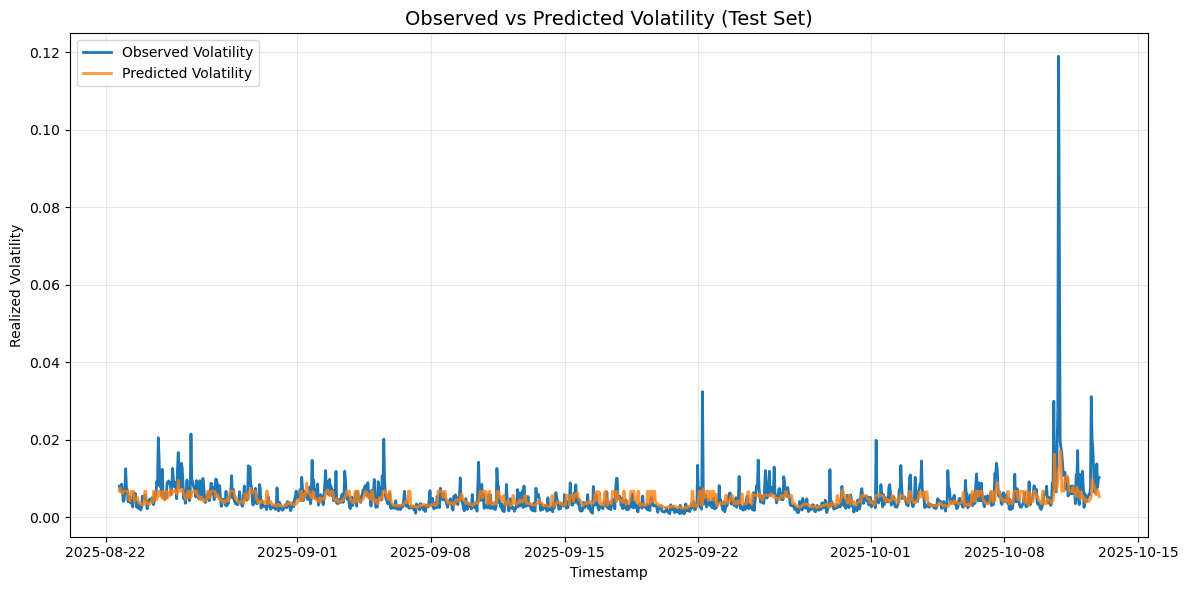

Test RMSE = 0.000425
Test RMPSE = 2.116764
Test QLIKE = 0.71396015


In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(t_test, y_true, label="Observed Volatility", linewidth=2)
plt.plot(t_test, yhat, label="Predicted Volatility", linewidth=2, alpha=0.8)
plt.title("Observed vs Predicted Volatility (Test Set)", fontsize=14)
plt.xlabel("Timestamp")
plt.ylabel("Realized Volatility")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Test RMSE = {rmse(np.square(y_true), np.square(yhat)):.6f}")
print(f"Test RMPSE = {rmpse(np.square(y_true), np.square(yhat)):.6f}")
print(f"Test QLIKE = {qlike_variance(np.square(y_true), np.square(yhat)):.8f}")


In [16]:
from captum.attr import IntegratedGradients, DeepLift, Saliency

xb_sample = torch.tensor(X_test_s[-10:], dtype=torch.float32).to(DEVICE) 
yb_sample = torch.tensor(y_test_s[-10:], dtype=torch.float32).to(DEVICE)
def forward_fn(x):
    return model(x).squeeze(1)
ig = IntegratedGradients(forward_fn)
attributions, delta = ig.attribute(
    xb_sample,
    target=None,
    n_steps=50,
    return_convergence_delta=True
)

In [17]:
attr_mean = attributions.mean(dim=(0, 1)).detach().cpu().numpy()
attr_abs = np.abs(attr_mean)  

feat_importance = (
    pd.DataFrame({
        "feature": num_cols,
        "importance": attr_abs
    })
    .sort_values("importance", ascending=False)
    .head(20)  
)

print(feat_importance.head(10))


               feature  importance
2           RV_MA_12hr    0.218247
11               close    0.197527
12       hourly_return    0.188988
0            RV_MA_1hr    0.179982
10                high    0.148866
1            RV_MA_3hr    0.143373
6    transaction_count    0.123148
16  staking_inflow_log    0.118810
9                  low    0.110422
8                 open    0.088288


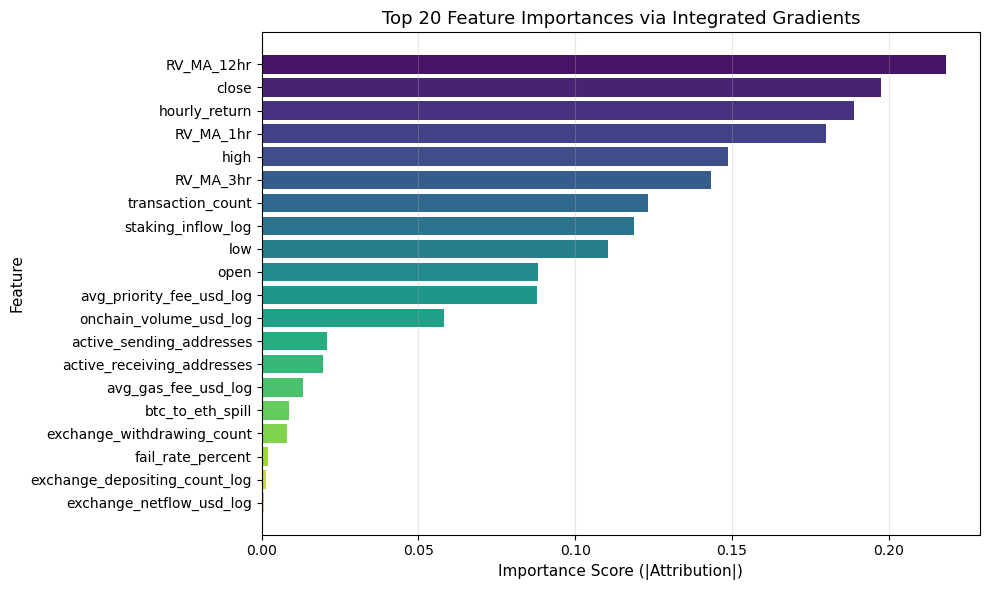

In [18]:
plt.figure(figsize=(10, 6))
colors = sns.color_palette("viridis", len(feat_importance))
plt.barh(feat_importance["feature"][::-1], feat_importance["importance"][::-1], color=colors[::-1])
plt.title("Top 20 Feature Importances via Integrated Gradients", fontsize=13)
plt.xlabel("Importance Score (|Attribution|)", fontsize=11)
plt.ylabel("Feature", fontsize=11)
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


In [19]:
pred_df = pd.DataFrame({
    "timestamp": pd.to_datetime(t_test),
    "observed_volatility": y_true,
    "predicted_volatility": yhat
})

In [20]:
save_path = "../../Results/eth_transformer_dense_prediction.csv"
pred_df.to_csv(save_path, index=False)
print(f"✅ Saved test predictions to {save_path}")
print(pred_df.head())


✅ Saved test predictions to ../../Results/eth_transformer_dense_prediction.csv
            timestamp  observed_volatility  predicted_volatility
0 2025-08-22 17:00:00             0.007970              0.006684
1 2025-08-22 18:00:00             0.007213              0.007467
2 2025-08-22 19:00:00             0.006859              0.006521
3 2025-08-22 20:00:00             0.008493              0.006274
4 2025-08-22 21:00:00             0.006617              0.006047
